In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import glob
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode

/opt/conda/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


## Dataset Prepare

In [2]:
def get_ead_dicts(img_dir):    
    images_path = os.path.join(img_dir, '*.jpg')
    images = glob.glob(images_path)
    
    dataset_dicts = []
    
    for idx, image_path in enumerate(images):
        text_path= image_path.replace(".jpg", ".txt")
        
        record = {}

        height, width = cv2.imread(image_path).shape[:2]
        
        record["file_name"] = image_path
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width        
        
        with open(text_path) as f:
            contents = f.readlines()
        
        objs = []
        for content in contents:
            information = content.split(' ')
            
            obj = {
                "bbox": [(float(information[1]) - float(information[3]) / 2)*width, 
                         (float(information[2]) - float(information[4]) / 2)*height, 
                         (float(information[1]) + float(information[3]) / 2)*width, 
                         (float(information[2]) + float(information[4]) / 2)*height],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": int(information[0])
            }
            objs.append(obj)
                        
        record["annotations"] = objs
        dataset_dicts.append(record)                        
    return dataset_dicts

In [3]:
from detectron2.data import DatasetCatalog, MetadataCatalog

DatasetCatalog.clear()

train_path = r'/home/ws2080/Desktop/data/training/train_augmented/'
validation_path = r'/home/ws2080/Desktop/data/training/validation/'

d= 'train'
DatasetCatalog.register("ead_train_1", lambda d=d: get_ead_dicts(train_path))
MetadataCatalog.get("ead_train_1").set(thing_classes=["specularity", "saturation", "artifact", "blur", "contrast", "bubbles", "instrument", "blood"])

d= 'validation'
DatasetCatalog.register("ead_validation_1", lambda d=d: get_ead_dicts(validation_path))
MetadataCatalog.get("ead_validation_1").set(thing_classes=["specularity", "saturation", "artifact", "blur", "contrast", "bubbles", "instrument", "blood"])

Metadata(name='ead_validation_1', thing_classes=['specularity', 'saturation', 'artifact', 'blur', 'contrast', 'bubbles', 'instrument', 'blood'])

/home/ws2080/Desktop/data/training/train_augmented/EAD2020_frameOnly_01718_0_flipped.jpg


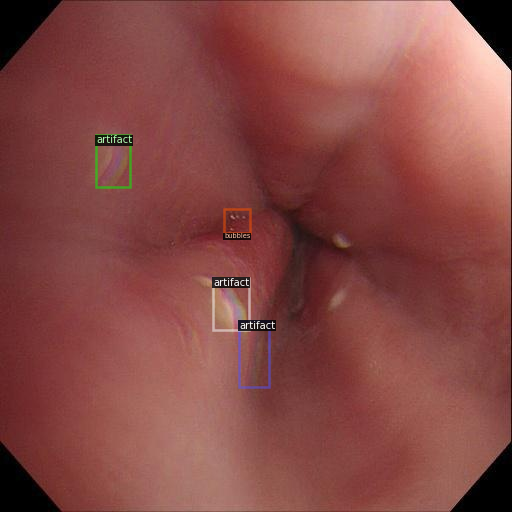

In [4]:
ead_metadata = MetadataCatalog.get("ead_train_1")
dataset_dicts = get_ead_dicts(train_path)

for d in random.sample(dataset_dicts, 1):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=ead_metadata)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Training

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("ead_train_1",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml") 
cfg.SOLVER.IMS_PER_BATCH = 8       
cfg.MODEL.RETINANET.NUM_CLASSES = 8  
cfg.MODEL.RETINANET.FOCAL_LOSS_GAMMA = 2.5

#Gorkem
cfg.INPUT.MIN_SIZE_TRAIN = (512,)
cfg.INPUT.MAX_SIZE_TRAIN = 512
cfg.INPUT.MIN_SIZE_TEST = 512
cfg.INPUT.MAX_SIZE_TEST = 512

cfg.SOLVER.BASE_LR = 0.01  # pick a good LR
cfg.SOLVER.STEPS = (60000, 80000)
cfg.SOLVER.CHECKPOINT_PERIOD = 10000
cfg.SOLVER.MAX_ITER = 90000

config_yaml = cfg.dump()
text_file = open("output/config.yaml", "w")
text_file.write(config_yaml)
text_file.close()

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()


Loading config /opt/conda/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[03/01 14:49:26 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

[03/01 14:50:41 d2.data.build]: Removed 0 images with no usable annotations. 17848 images left.
[03/01 14:50:41 d2.data.build]: Distribution of instances among all 8 categories:
|  category   | #instances   |  category  | #instances   |  category  | #instances   |
|:-----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| specularity | 83680        | saturation | 10000        |  artifact  | 61800        |
|    blur     | 5224         |  contrast  | 13136        |  bubbles   | 37784        |
| instrument  | 4344         |   blood    | 3800         |            |              |
|    total    | 219768       |            |              |            |              |
[03/01 14:50:41 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(512,), max_size=512, sample_style='choice'), RandomFlip()]
[03/01 14:50:41 d2.data.build]: Using training sampler TrainingSampler


'head.cls_score.weight' has shape (720, 256, 3, 3) in the checkpoint but (72, 256, 3, 3) in the model! Skipped.
'head.cls_score.bias' has shape (720,) in the checkpoint but (72,) in the model! Skipped.


[03/01 14:50:43 d2.engine.train_loop]: Starting training from iteration 0
[03/01 14:50:53 d2.utils.events]: eta: 10:30:05  iter: 19  total_loss: 1.583  loss_cls: 1.113  loss_box_reg: 0.475  time: 0.4308  data_time: 0.0918  lr: 0.000200  max_mem: 3341M
[03/01 14:51:01 d2.utils.events]: eta: 10:31:59  iter: 39  total_loss: 1.441  loss_cls: 1.008  loss_box_reg: 0.438  time: 0.4296  data_time: 0.0730  lr: 0.000400  max_mem: 3341M
[03/01 14:51:10 d2.utils.events]: eta: 10:32:30  iter: 59  total_loss: 1.184  loss_cls: 0.778  loss_box_reg: 0.461  time: 0.4282  data_time: 0.0812  lr: 0.000599  max_mem: 3342M
[03/01 14:51:18 d2.utils.events]: eta: 10:32:40  iter: 79  total_loss: 0.976  loss_cls: 0.595  loss_box_reg: 0.391  time: 0.4266  data_time: 0.0750  lr: 0.000799  max_mem: 3342M
[03/01 14:51:27 d2.utils.events]: eta: 10:33:03  iter: 99  total_loss: 0.885  loss_cls: 0.507  loss_box_reg: 0.388  time: 0.4278  data_time: 0.0849  lr: 0.000999  max_mem: 3342M
[03/01 14:51:36 d2.utils.events]: et

[03/01 14:57:15 d2.utils.events]: eta: 10:34:30  iter: 899  total_loss: 0.648  loss_cls: 0.295  loss_box_reg: 0.327  time: 0.4320  data_time: 0.0785  lr: 0.008991  max_mem: 3342M
[03/01 14:57:24 d2.utils.events]: eta: 10:34:41  iter: 919  total_loss: 0.549  loss_cls: 0.256  loss_box_reg: 0.308  time: 0.4322  data_time: 0.0852  lr: 0.009191  max_mem: 3342M
[03/01 14:57:32 d2.utils.events]: eta: 10:34:39  iter: 939  total_loss: 0.580  loss_cls: 0.282  loss_box_reg: 0.282  time: 0.4323  data_time: 0.0801  lr: 0.009391  max_mem: 3342M
[03/01 14:57:41 d2.utils.events]: eta: 10:34:39  iter: 959  total_loss: 0.568  loss_cls: 0.273  loss_box_reg: 0.292  time: 0.4324  data_time: 0.0735  lr: 0.009590  max_mem: 3342M
[03/01 14:57:50 d2.utils.events]: eta: 10:34:48  iter: 979  total_loss: 0.592  loss_cls: 0.263  loss_box_reg: 0.315  time: 0.4325  data_time: 0.0751  lr: 0.009790  max_mem: 3342M
[03/01 14:57:59 d2.utils.events]: eta: 10:35:08  iter: 999  total_loss: 0.541  loss_cls: 0.267  loss_box_

[03/01 15:03:47 d2.utils.events]: eta: 10:46:25  iter: 1779  total_loss: 0.577  loss_cls: 0.234  loss_box_reg: 0.360  time: 0.4373  data_time: 0.0883  lr: 0.010000  max_mem: 3342M
[03/01 15:03:55 d2.utils.events]: eta: 10:46:27  iter: 1799  total_loss: 0.527  loss_cls: 0.238  loss_box_reg: 0.288  time: 0.4373  data_time: 0.0707  lr: 0.010000  max_mem: 3342M
[03/01 15:04:04 d2.utils.events]: eta: 10:46:37  iter: 1819  total_loss: 0.502  loss_cls: 0.231  loss_box_reg: 0.276  time: 0.4374  data_time: 0.0884  lr: 0.010000  max_mem: 3342M
[03/01 15:04:13 d2.utils.events]: eta: 10:46:42  iter: 1839  total_loss: 0.539  loss_cls: 0.224  loss_box_reg: 0.289  time: 0.4374  data_time: 0.0747  lr: 0.010000  max_mem: 3342M
[03/01 15:04:22 d2.utils.events]: eta: 10:46:46  iter: 1859  total_loss: 0.500  loss_cls: 0.235  loss_box_reg: 0.254  time: 0.4374  data_time: 0.0744  lr: 0.010000  max_mem: 3342M
[03/01 15:04:31 d2.utils.events]: eta: 10:46:46  iter: 1879  total_loss: 0.563  loss_cls: 0.250  los

[03/01 15:10:19 d2.utils.events]: eta: 10:44:13  iter: 2659  total_loss: 0.492  loss_cls: 0.207  loss_box_reg: 0.264  time: 0.4395  data_time: 0.0759  lr: 0.010000  max_mem: 3342M
[03/01 15:10:28 d2.utils.events]: eta: 10:44:03  iter: 2679  total_loss: 0.487  loss_cls: 0.227  loss_box_reg: 0.260  time: 0.4395  data_time: 0.0719  lr: 0.010000  max_mem: 3342M
[03/01 15:10:38 d2.utils.events]: eta: 10:43:56  iter: 2699  total_loss: 0.454  loss_cls: 0.207  loss_box_reg: 0.246  time: 0.4396  data_time: 0.0776  lr: 0.010000  max_mem: 3342M
[03/01 15:10:46 d2.utils.events]: eta: 10:43:47  iter: 2719  total_loss: 0.491  loss_cls: 0.216  loss_box_reg: 0.256  time: 0.4396  data_time: 0.0714  lr: 0.010000  max_mem: 3342M
[03/01 15:10:55 d2.utils.events]: eta: 10:43:37  iter: 2739  total_loss: 0.531  loss_cls: 0.221  loss_box_reg: 0.283  time: 0.4397  data_time: 0.0854  lr: 0.010000  max_mem: 3342M
[03/01 15:11:04 d2.utils.events]: eta: 10:43:33  iter: 2759  total_loss: 0.470  loss_cls: 0.222  los

[03/01 15:16:55 d2.utils.events]: eta: 10:39:19  iter: 3539  total_loss: 0.468  loss_cls: 0.212  loss_box_reg: 0.254  time: 0.4412  data_time: 0.0828  lr: 0.010000  max_mem: 3342M
[03/01 15:17:04 d2.utils.events]: eta: 10:39:23  iter: 3559  total_loss: 0.519  loss_cls: 0.214  loss_box_reg: 0.289  time: 0.4412  data_time: 0.0782  lr: 0.010000  max_mem: 3342M
[03/01 15:17:13 d2.utils.events]: eta: 10:39:10  iter: 3579  total_loss: 0.493  loss_cls: 0.209  loss_box_reg: 0.276  time: 0.4413  data_time: 0.0804  lr: 0.010000  max_mem: 3342M
[03/01 15:17:22 d2.utils.events]: eta: 10:38:52  iter: 3599  total_loss: 0.451  loss_cls: 0.199  loss_box_reg: 0.248  time: 0.4412  data_time: 0.0742  lr: 0.010000  max_mem: 3342M
[03/01 15:17:31 d2.utils.events]: eta: 10:38:48  iter: 3619  total_loss: 0.498  loss_cls: 0.215  loss_box_reg: 0.281  time: 0.4413  data_time: 0.0787  lr: 0.010000  max_mem: 3342M
[03/01 15:17:40 d2.utils.events]: eta: 10:38:50  iter: 3639  total_loss: 0.523  loss_cls: 0.204  los

## Inference

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("ead_validation_1", )
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_ead_dicts(validation_path)
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=ead_metadata
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("ead_validation_1", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "ead_validation_1")
a = inference_on_dataset(trainer.model, val_loader, evaluator)


In [ ]:
print(a)

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
a.get('bbox')

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

cfg = get_cfg()

cfg.merge_from_file("output/config.yaml")
cfg.MODEL.WEIGHTS = os.path.join("output", "model_final.pth")

trainer = DefaultTrainer(cfg)

evaluator = COCOEvaluator("ead_validation_1", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "ead_validation_1")
a = inference_on_dataset(trainer.model, val_loader, evaluator)

In [ ]:
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
cfg = get_cfg()
cfg.merge_from_file("output/config.yaml")

model = build_model(cfg)
DetectionCheckpointer(model).load("output/model_final.pth")

evaluator = COCOEvaluator("ead_validation_1", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "ead_validation_1")
a = inference_on_dataset(model, val_loader, evaluator)